# 2.1. Деревья решений. Классификация

### Agenda:
* критерий информативности с нуля
* визуализация разделяющих поверхностей решения и визуализация самого дерева
* оценка важности фичей
* ужасы переобучения

## 1. Критерий информативности с нуля

как мы разобрали, построение дерева зависит от следующих факторов:
* вид правила разбиения
* критерий информативности
* критерий останова
* метод стрижки
* проблема пропусков

пройдёмся критериям информативности

In [1]:
import numpy as np
from collections import Counter

*Нам понадобятся две библиотеки: numpy вы знаете, а объект класса Counter в заданном списке просто подсчитывает количество вхождений каждого элемента и возвращает результат в виде словаря. Пример:*

In [2]:
Counter([9,9,9,7,7])

Counter({9: 3, 7: 2})

In [4]:
Counter([9,9,9,7,7]).values()

dict_values([3, 2])

*Для численного измерения улучшения разбиений на каждом этапе мы вводим некоторый *критерий информативности*, который будет оценивать разнообразие объектов в выборке: чем больше разных классов в выборке, тем больше значение H(R). Чем меньше взвешенное значение критерия после разбиения - тем лучше*

Ниже представлена функция для расчёта энтропийного критерия качества:

$H(R) = -\sum_{k=1}^{K}p_klogp_k$

**Задание.** Дополните функцию расчёта энтропийного критерия множества

In [7]:
def HEntropy(l):
    length = len(l)
    cnt = Counter(l)
    hr = [x / length  for x in cnt.values()]
    return -sum([x*np.log(x) for x in hr])
    #pass #your code

In [8]:
l  = [1,1,1,2,2,2,1,1]

In [9]:
HEntropy(l)

0.6615632381579821

**Задание.** По аналогии с *энтропийным критерием* заполните функции *критерия Джини*

In [12]:
def HGini(l):
    #your code
    length = len(l)
    cnt = Counter(l)
    hr = [x / length  for x in cnt.values()]
    return sum([x*(1-x) for x in hr])

In [13]:
HGini(l)

0.46875

*Information Gain (IG)* - функционал качества, отвечающий на вопрос, а сколько энтропии мы погасили при определённом разбиении? На каждом шаге разбиения при построении дерева максимизируется IG. Формула для вычисления при критерии информативности H:

$IG(R) = H(R) - \frac{|R_l|}{|R|}H(R_l) - \frac{|R_r|}{|R|}H(R_r)$

**Задание.** Заполните функцию для вычисления функционала качества

In [15]:
def IG(H, l, i):
    length = len(l)
    hr = H(l)
    hrl = H(l[:i])
    hrr = H(l[i:])
    return hr - i/length*hrl - (length - i)/length*hrr
    #your code

Здесь я подготовил функцию для визуализации работы произвольного критерия качества на выборке

In [16]:
def test_H(H, l):
    print("{:5} {:3}   {:4} {:4} {:4}".format("#","l","IG","Hl","Hr"))
    print("-"*24)
    for i in range(1,len(l)):
        print("{:2}. {:3}   {:.2f} {:.2f} {:.2f}".format(i, l[i], IG(H, l, i), H(l[:i]), H(l[i:])))

Ну что, определим как-нибудь выборку и посмотрим, какое разбиение предложат критерии информативности. Замечу, что элементы здесь будут выводиться начиная со второго, а значения функций рассчитаны для разбиения *перед* элементом строки

In [17]:
l = [1]*5 + [2]*3 + [1]*4
print(l)

[1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1]


In [18]:
test_H(HEntropy, l)

#     l     IG   Hl   Hr  
------------------------
 1.   1   0.03 -0.00 0.59
 2.   1   0.05 -0.00 0.61
 3.   1   0.08 -0.00 0.64
 4.   1   0.12 -0.00 0.66
 5.   2   0.16 -0.00 0.68
 6.   2   0.02 0.45 0.64
 7.   2   0.00 0.60 0.50
 8.   1   0.12 0.66 -0.00
 9.   1   0.08 0.64 -0.00
10.   1   0.05 0.61 -0.00
11.   1   0.03 0.59 -0.00


In [19]:
test_H(HGini, l)

#     l     IG   Hl   Hr  
------------------------
 1.   1   0.01 0.00 0.40
 2.   1   0.02 0.00 0.42
 3.   1   0.04 0.00 0.44
 4.   1   0.06 0.00 0.47
 5.   2   0.09 0.00 0.49
 6.   2   0.01 0.28 0.44
 7.   2   0.00 0.41 0.32
 8.   1   0.06 0.47 0.00
 9.   1   0.04 0.44 0.00
10.   1   0.02 0.42 0.00
11.   1   0.01 0.40 0.00


**Задание.** проверьте, какое разбиение будет сделано на втором шаге?

In [ ]:
pass #your code

## 2. Визуализация принятия решений классификатором sklearn

#### 1. Используем данные о цветках ириса из занятия

In [20]:
from sklearn.datasets import load_iris
import pandas as pd

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [22]:
iris = load_iris()

In [23]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=['species'])
df = pd.concat([X,y], axis=1)

In [24]:
print(df.shape)
df.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Выведем попарное распределение фичей датасета с раскраской по виду цветка

C:\Users\viktoria.sinditskaya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\viktoria.sinditskaya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


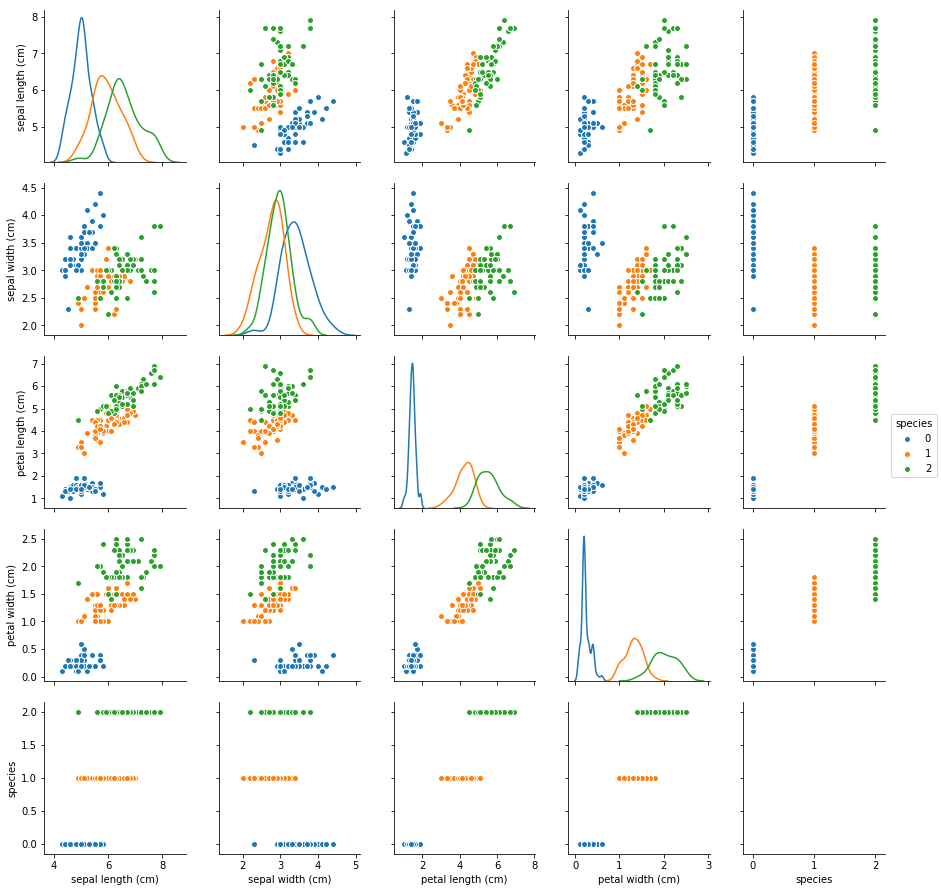

In [25]:
sns.pairplot(df, hue='species', diag_kind="kde")

визуально кажется, что ширина листка (petal width) даже самостоятельно может отделить два класса друг от друга идеально, а ещё для двух понадобится хотя бы ещё одна фича.

Возьмём пока для возможности изобразить это в 2D две фичи: длину и ширину листка

In [26]:
Xcut = X[X.columns[2:4]]

#### 2. Используем классификатор

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
DecisionTreeClassifier?

In [28]:
clf = DecisionTreeClassifier()

In [29]:
clf.fit(Xcut, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [30]:
clf.predict([ [1,1], [3,3] ])

array([1, 2])

In [31]:
clf.predict_proba([ [1,1], [3,3] ])

array([[0.        , 1.        , 0.        ],
       [0.        , 0.33333333, 0.66666667]])

Супер, можем теперь предсказывать. Давайте визуализируем границу принятия решений. Для удобства экспереминтирования я упаковал всё в функцию **test_clf**, в неё передаётся созданный классификатор и при установленном fit_clf=True обучается внутри, а затем отрисовывает границу. Таким образом можно экспериментировать с параметрами классификатора

In [34]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [103]:
def test_clf(clf, X, y, cmap=None, fit_clf=False,c=None):
    xx,yy = get_grid(X.values)
    if fit_clf:
        clf.fit(X, y)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, predicted, cmap=cmap or 'spring')
    plt.scatter(X.values[:, 0], X.values[:, 1], c=c, s=100)
    if fit_clf:
        return clf

*попробуйте при разной глубине*

In [105]:
labels = y['species'].values

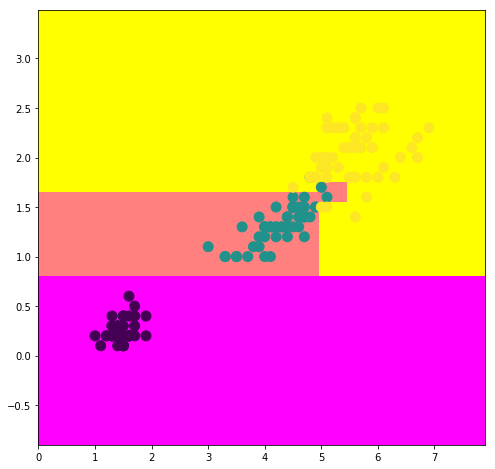

In [106]:
clf = test_clf(DecisionTreeClassifier(), Xcut, y,c=labels, fit_clf=True)

обратите внимание, один блок занимает то позицию снизу, то слева: данных недостаточно для принятия однозначного решения и экстраполяция идёт произвольно

#### 3. Визуализируем само дерево

Возможно, самое замечательное свойство одиночных деревьев - возможность визуализировать их алгоритм работы и затем объяснить его хоть человеку, хоть машине

Дерево можно как-то отобразить внутри ipython-ноутбука с помощью библиотеки pydot и установлнного webgraphviz, но мы воспользуемся скорее онлайн-сервисом http://www.webgraphviz.com

Сгенерируем код дерева в формате .dot и скопируем его на сайт

In [75]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None, out_file=None):
    print(export_graphviz(clf, out_file=out_file, filled=True, feature_names=feature_names, class_names=class_names))

In [76]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(Xcut, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [78]:
get_tree_dot_view(clf,  list(Xcut.columns), iris.target_names,out_file='tree.dot')

None


-----

In [79]:
from graphviz import Digraph
import graphviz

In [91]:
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)   

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [85]:
!pip show graphviz

Name: graphviz
Version: 0.10.1
Summary: Simple Python interface for Graphviz
Home-page: https://github.com/xflr6/graphviz
Author: Sebastian Bank
Author-email: sebastian.bank@uni-leipzig.de
License: MIT
Location: c:\users\viktoria.sinditskaya\appdata\local\continuum\anaconda3\lib\site-packages
Requires: 
Required-by: eli5


In [87]:
import os
os.environ["PATH"] += os.pathsep + r'c:\users\viktoria.sinditskaya\appdata\local\continuum\anaconda3\lib\site-packages'

**Задание**
1. визуализировать дерево
2. вставить скрин с картинкой сюда в ipython notebook (!\[text](imagename.png))
3. проверить индексы Джини в узлах: совпадают с нашей расчётной функцией?
4. ветка налево - это True или False? что значит цвет узла? class? values?

-----

## 3. Оценка важности фичей

важность зависит от конкретного прогона классификатора, это не объективный показатель, но дающий представление

*попробуйте при разной глубине*

''

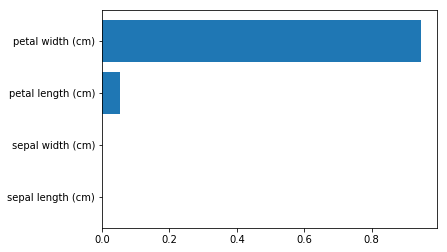

In [92]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(X.columns)),X.columns)
''

## 4. Переообучение наглядно

*здесь я использую генерацию датасета из [блога](https://habrahabr.ru/company/ods/blog/322534/) open data science*

In [94]:
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]
train_data = pd.DataFrame(train_data)

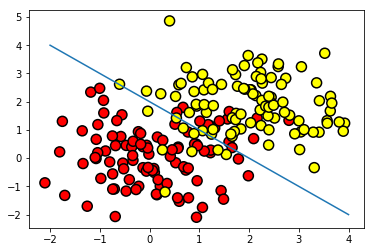

In [95]:
plt.scatter(train_data[0], train_data[1], c=train_labels, s=100, cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

*попробуйте при разной глубине*

In [102]:
 train_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

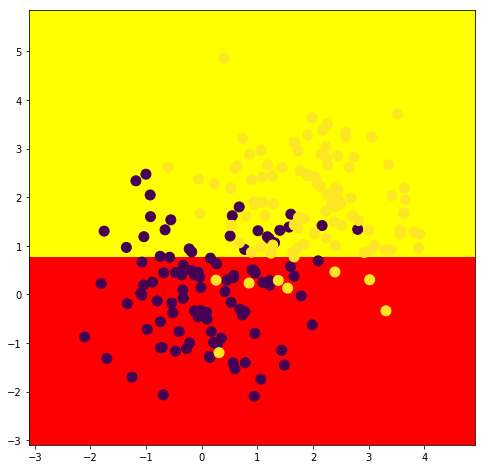

In [107]:
clf = test_clf(DecisionTreeClassifier(max_depth=1), train_data, train_labels,c=train_labels, cmap='autumn', fit_clf=True)

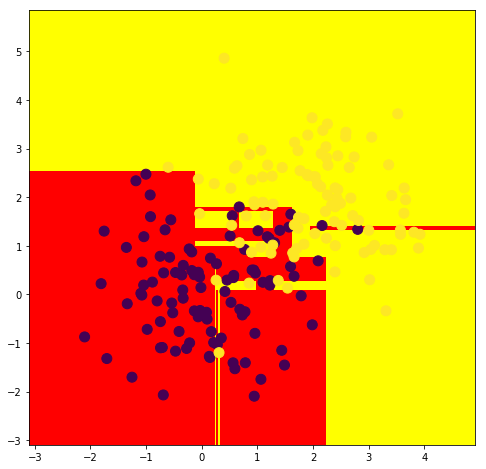

In [108]:
clf = test_clf(DecisionTreeClassifier(), train_data, train_labels,c=train_labels, cmap='autumn', fit_clf=True)

А здесь можно увидеть огромное переобученное дерево: http://www.webgraphviz.com

In [93]:
get_tree_dot_view(DecisionTreeClassifier(max_depth=10), feature_names=['x','y'])

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.